In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn import metrics
from xgboost.sklearn import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold, train_test_split

C:\Users\Hradi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [3]:
data = pd.read_csv('data.csv', sep=';', header=0, index_col=24)
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,31.10.2000,LAL @ POR,POR
2,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,31.10.2000,LAL @ POR,POR
3,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,31.10.2000,LAL @ POR,POR
4,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,31.10.2000,LAL @ POR,POR
5,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,31.10.2000,LAL @ POR,POR


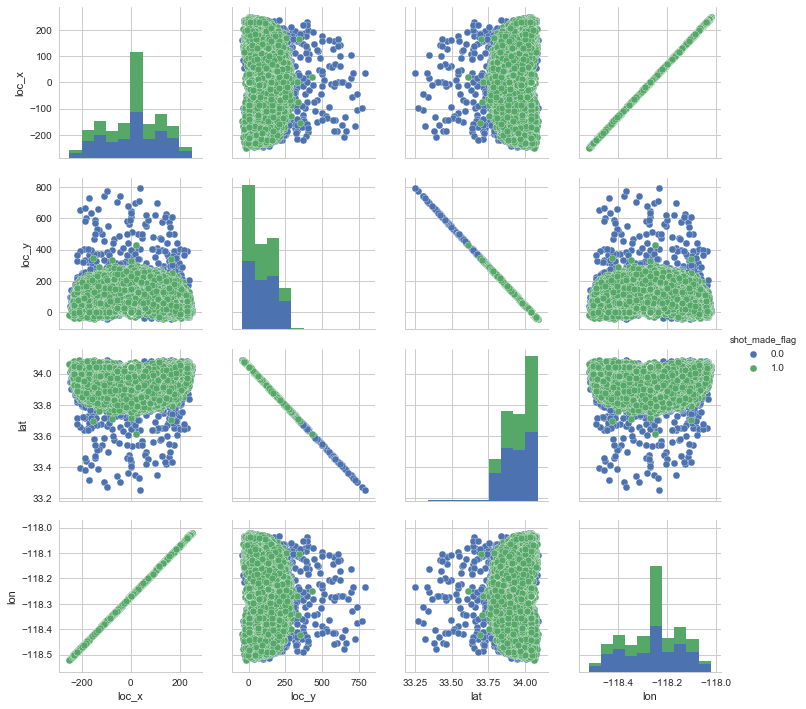

In [4]:
sns.set_style('whitegrid')
sns.pairplot(data, vars=['loc_x', 'loc_y', 'lat', 'lon'], hue='shot_made_flag')

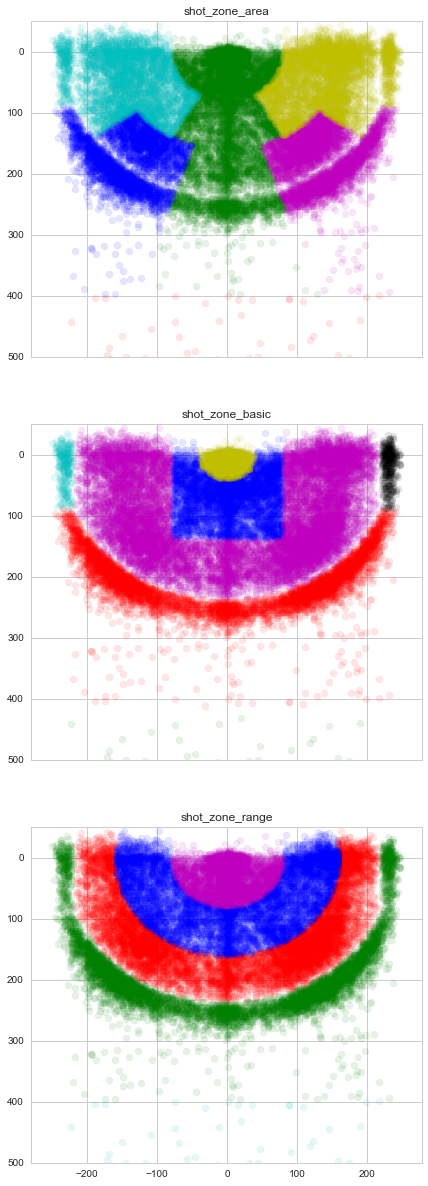

In [5]:
area_group = data.groupby('shot_zone_area')
basic_group = data.groupby('shot_zone_basic')
range_group = data.groupby('shot_zone_range')

f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(7, 21))
colors = list('rgbcmyk')

plt.ylim(500, -50)
ax1.set_title('shot_zone_area')
for i, (_, area) in enumerate(area_group):
    ax1.scatter(area['loc_x'], area['loc_y'], alpha=0.1, color=colors[i])
    

ax2.set_title('shot_zone_basic')
for i, (_, basic) in enumerate(basic_group):
    ax2.scatter(basic['loc_x'], basic['loc_y'], alpha=0.1, color=colors[i])

ax3.set_title('shot_zone_range')
for i, (_, basic) in enumerate(range_group):
    ax3.scatter(basic['loc_x'], basic['loc_y'], alpha=0.1, color=colors[i])

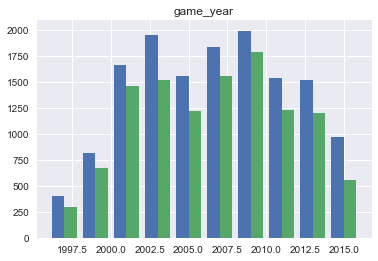

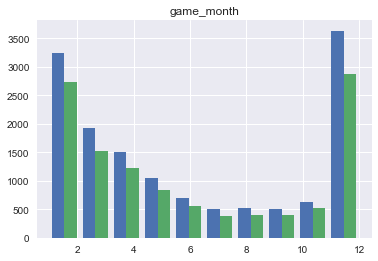

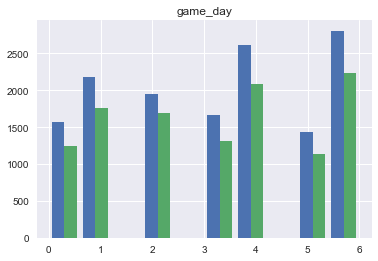

In [4]:
data['game_date'] = pd.to_datetime(data['game_date'])
data['game_year'] = data['game_date'].dt.year
data['game_month'] = data['game_date'].dt.month
data['game_day'] = data['game_date'].dt.dayofweek

#f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(7, 21))
plt.figure(1)  
plt.title('game_year')
x0 = plt.hist([data[data.shot_made_flag==0]['game_year'], data[data.shot_made_flag==1]['game_year']])
plt.figure(2)
plt.title('game_month')
x1 = plt.hist([data[data.shot_made_flag==0]['game_month'], data[data.shot_made_flag==1]['game_month']])
plt.figure(4)
plt.title('game_day')
x2 = plt.hist([data[data.shot_made_flag==0]['game_day'], data[data.shot_made_flag==1]['game_day']])

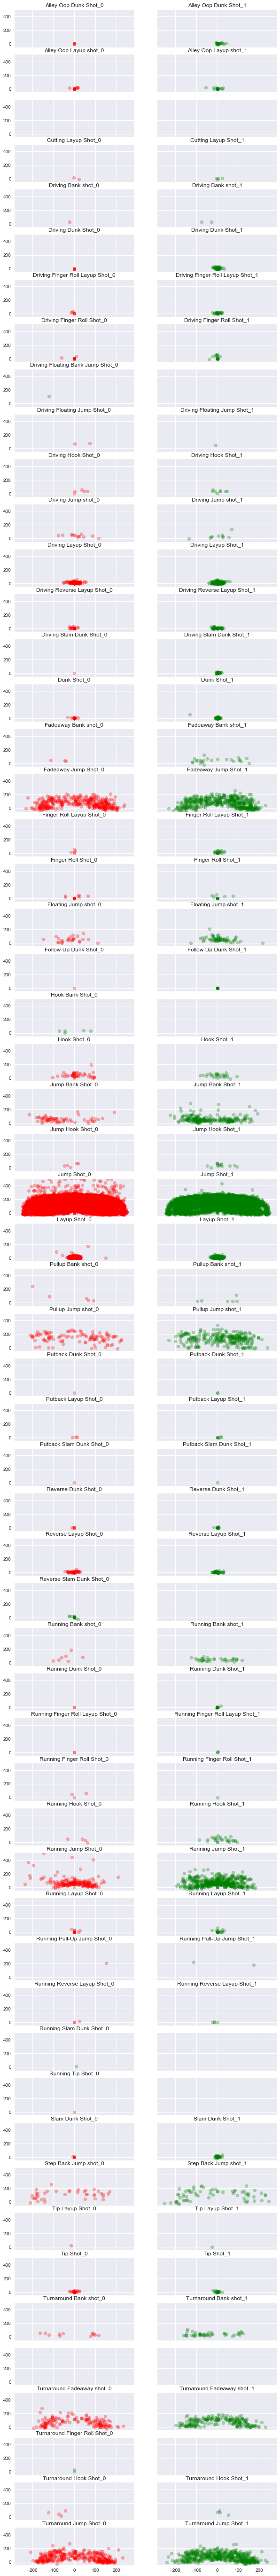

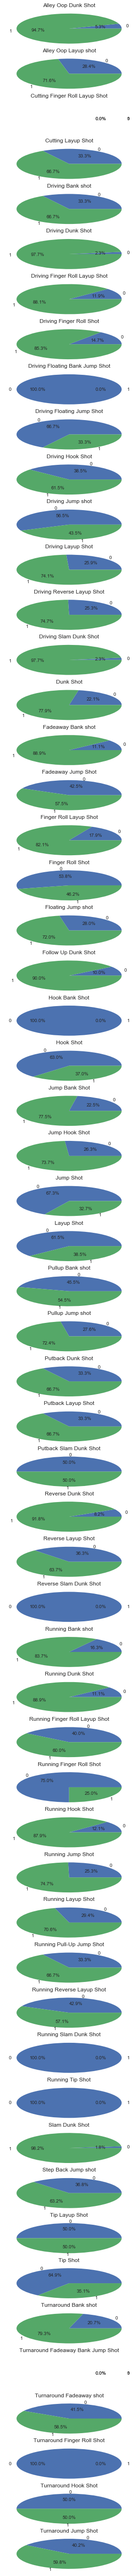

In [5]:
action_type_col = data.action_type.unique()
action_group = data.groupby('action_type')
f, axs = plt.subplots(len(action_type_col), 2, sharex=True, sharey=True, figsize=(10, 100))
cool_action_types = []


color = ['r', 'g']
plt.ylim(-50, 500)
for i, (_, action) in enumerate(action_group):
    s_made_gr = action.groupby('shot_made_flag')
    for j, (_, s_made) in enumerate(s_made_gr):
        axs[i][j].set_title(action['action_type'].any()+"_%i" % j)
        axs[i][j].scatter(s_made['loc_x'], s_made['loc_y'], color=color[s_made['shot_made_flag'].any()], alpha=0.3)
    
f, axs2 = plt.subplots(len(action_type_col), figsize=(5, 100))
for i, (_, action) in enumerate(action_group):
    s_made_gr = action.groupby('shot_made_flag')
    axs2[i].set_title(action['action_type'].any())
    sizes = [0, 0]
    for j, (_, s_made) in enumerate(s_made_gr):
        sizes[j] = s_made.count().sum()
    axs2[i].pie(sizes, labels=[0, 1], autopct='%1.1f%%')
    if sum(sizes) == 0 or sizes[0]/sum(sizes) > 0.7 or sizes[1]/sum(sizes) > 0.7:
        continue
    cool_action_types.append(action['action_type'].any())

#data.loc[data['action_type'].isin(cool_action_types), 'action_type'] = 'Other'
dum = pd.get_dummies(data['action_type'])
data = data.join(dum[cool_action_types])
#data = data.drop(['action_type'], axis=1)


ValueError: columns overlap but no suffix specified: Index(['Hook Shot', 'Jump Shot', 'Tip Shot'], dtype='object')

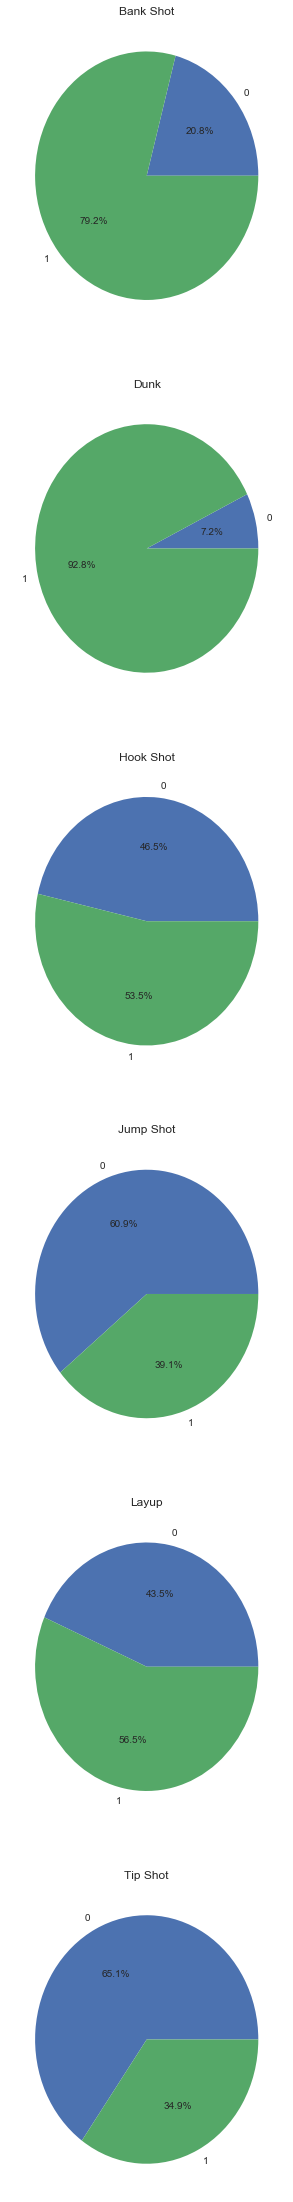

In [6]:
combined_shot_type_col = data.combined_shot_type.unique()
cs_group = data.groupby('combined_shot_type')
combined_shot_cool = []

f, axs2 = plt.subplots(len(combined_shot_type_col), figsize=(5, 40))
for i, (_, cs) in enumerate(cs_group):
    s_made_gr = cs.groupby('shot_made_flag')
    axs2[i].set_title(cs['combined_shot_type'].any())
    sizes = [0, 0]
    for j, (_, s_made) in enumerate(s_made_gr):
        sizes[j] = s_made.count().sum()
    axs2[i].pie(sizes, labels=[0, 1], autopct='%1.1f%%')
    if sum(sizes) == 0 or sizes[0]/sum(sizes) > 0.7 or sizes[1]/sum(sizes) > 0.7:
        continue
    combined_shot_cool.append(cs['combined_shot_type'].any())

dum = pd.get_dummies(data['combined_shot_type'])
data = data.join(dum[combined_shot_cool])
#data = data.drop(['combined_shot_type'], axis=1)

In [23]:
"""loc_y_col = data.loc_y.unique()
y_group = data.groupby('loc_y')
y_cool = []

#f, axs2 = plt.subplots(len(loc_y_col), figsize=(5, 40))
for i, (_, yg) in enumerate(y_group):
    s_made_gr = yg.groupby('shot_made_flag')
    #axs2[i].set_title(yg['loc_y'].any())
    if i%20 == 0:
        sizes = [0, 0]
    for j, (_, s_made) in enumerate(s_made_gr):
        sizes[j] += s_made.count().sum()
    #axs2[i].pie(sizes, labels=[0, 1], autopct='%1.1f%%')
    if i%20==0:
        if sum(sizes) == 0 or sizes[0]/sum(sizes) > 70 or sizes[1]/sum(sizes) > 70:
            continue
        y_cool.append(cs['loc_y'].any())

data.loc[data['loc_y'].isin(y_cool), 'loc_y'] = 1000
dum = pd.get_dummies(data['loc_y']).add_prefix('{}_'.format('loc_y'))
data = data.join(dum)"""
#data = data.drop(['loc_y'], axis=1)

In [ ]:
'shot_zone_area'

In [15]:
data.head()

,action_type,combined_shot_type,loc_x,loc_y,period,playoffs,season,shot_distance,shot_made_flag,shot_type,...,Tip Layup Shot,Tip Shot,Turnaround Fadeaway shot,Turnaround Hook Shot,Turnaround Jump Shot,event_in_game,time_remaining,last_time,x_abs,home_play
shot_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,167,72,1,0,7,18,NaN,0,...,0,0,0,0,0,11,627,0,167,0
2,0,0,-157,0,1,0,7,15,0.0,0,...,0,0,0,0,0,11,622,0,157,0
3,0,0,-101,135,1,0,7,16,1.0,0,...,0,0,0,0,0,11,465,0,101,0
4,0,0,138,175,1,0,7,22,0.0,0,...,0,0,0,0,0,11,412,0,138,0
5,11,2,0,0,2,0,7,0,1.0,0,...,0,0,0,0,0,11,379,0,0,0


In [7]:
def text_to_flags(data, column_name):
    action_set = data[column_name].value_counts().keys()
    action_id = range(len(action_set))
    dict_action_type = dict(zip(action_set, action_id))
    data[column_name] = data[column_name].map(dict_action_type).astype(int)

In [8]:
text_to_flags(data, 'action_type')
text_to_flags(data, 'combined_shot_type')
text_to_flags(data, 'shot_type')
text_to_flags(data, 'shot_zone_area')
text_to_flags(data, 'shot_zone_basic')
text_to_flags(data, 'shot_zone_range')
text_to_flags(data, 'opponent')
text_to_flags(data, 'season')
#text_to_flags(data, 'matchup')
text_to_flags(data, 'team_name')
text_to_flags(data, 'team_id')

keys = data['game_id'].value_counts().keys()
d = {}
for k in keys:
    d[k] = data[data.game_id == k].count()[0]
data['event_in_game'] = data['game_id'].map(d)
data['time_remaining'] = data['minutes_remaining'].apply(lambda x: x*60).add(data['seconds_remaining'])

datetime_now = datetime.datetime.now()
data['game_date'] = pd.to_datetime(data['game_date'])
data['game_date'] = data['game_date'].apply(lambda x: (datetime_now-x).days).astype(int)

data['last_time'] = data['time_remaining'].apply(lambda x: int(x<30))
data['x_abs'] = data['loc_x'].apply(lambda x: abs(x))

data['home_play'] = data['matchup'].str.contains('vs').astype('int')

In [9]:
data = data.drop(['team_name', 'minutes_remaining', 'seconds_remaining', 
                  'team_id', 'lat', 'lon', 'matchup', 'game_id', 'game_event_id'], axis=1)

In [10]:
data_columns = list(data.columns)
y_column = ['shot_made_flag']
data_columns.remove(y_column[0])
X_columns = data_columns

In [11]:
pred_data = data[data.shot_made_flag.isnull()]
train_data = data[data.shot_made_flag.notnull()]
pred_data = train_data[X_columns]

for col in X_columns:
    train_data[col] = preprocessing.scale(train_data[col])

x_train, x_test, y_train, y_test = train_test_split(train_data[X_columns], train_data[y_column], test_size=0.33)

In [12]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)
print('LogisticRegression: ',metrics.accuracy_score(y_pred_lr, y_test), sep='\t\t')

knn = KNeighborsClassifier(n_jobs =-1,n_neighbors = 80)
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_test)
print('KNeighborsClassifier: ',metrics.accuracy_score(y_pred_knn, y_test), sep='\t\t')

rf = RandomForestClassifier(n_jobs=-1,n_estimators=70, max_depth=7,random_state=1)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)
print('RandomForestClassifier: ',metrics.accuracy_score(y_pred_rf, y_test), sep='\t')
et = ExtraTreesClassifier(n_jobs=-1, n_estimators=250, random_state=1)
et.fit(x_train, y_train)
y_pred_et = et.predict(x_test)
print('ExtraTreesClassifier: ',metrics.accuracy_score(y_pred_et, y_test), sep='\t\t')

ab = AdaBoostClassifier(n_estimators = 120, learning_rate = 0.5, random_state=1)
ab.fit(x_train, y_train)
y_pred_ab = ab.predict(x_test)
print('AdaBoostClassifier: ',metrics.accuracy_score(y_pred_ab, y_test), sep='\t\t')

gb = GradientBoostingClassifier(learning_rate=0.08, n_estimators=79, random_state=1)
gb.fit(x_train, y_train)
y_pred_gb = gb.predict(x_test)
print('GradientBoostingClassifier: ',metrics.accuracy_score(y_pred_gb, y_test), sep='\t')

bound = np.vectorize(lambda x: int(x>=0.50))
linr = LinearRegression()
linr.fit(x_train, y_train)
y_pred_linr = linr.predict(x_test)
y_pred_linr = bound(y_pred_linr)
print('LinearRegression: ',metrics.accuracy_score(y_pred_linr, y_test), sep='\t\t')

LogisticRegression: 		0.68659356208
KNeighborsClassifier: 		0.6752741422
RandomForestClassifier: 	0.685296545219
ExtraTreesClassifier: 		0.663483079825
AdaBoostClassifier: 		0.686004008961
GradientBoostingClassifier: 	0.687065204575
LinearRegression: 		0.686711472704


In [14]:
results_list = np.array([y_pred_gb, y_pred_ab, y_pred_rf, y_pred_xgb])
bound = np.vectorize(lambda x: int(x>=0.50))
results = bound(results_list.mean(axis=0))
print(metrics.accuracy_score(results, y_test))


0.685768187714


In [13]:
xgb = XGBClassifier(max_depth=7, learning_rate=0.011, n_estimators=320, subsample=0.5, colsample_bytree=0.8, seed=1)
xgb.fit(x_train, y_train)
y_pred_xgb = xgb.predict(x_test)
print('XGBClassifier: ',metrics.accuracy_score(y_pred_xgb, y_test), sep='\t')


XGBClassifier: 	0.684353260229
